In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import astropy.coordinates as astro_coord
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#sns.set_style("dark")

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
#mpl.rcParams['axes.labelsize'] = 20
#mpl.rcParams['xtick.labelsize'] =20
#mpl.rcParams['ytick.labelsize'] = 20
#mpl.rcParams['legend.fontsize'] = 20
#mpl.rcParams['figure.titlesize'] = 20
from astropy.coordinates import Angle
import astropy.table as astrotable

splat.initializeStandards(all=True)
from scipy.interpolate import griddata, interpn
import splat.empirical as spe
%matplotlib inline


/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
#IGNORE G AND R BAND CUTS, NOT TOO MANY OBJECTS WITH THESE
PS1_DEPTHS={ 'Y':21.4} #'R':23.2, 'I':23.1  'Z':22.3 something funny happening
SDSS_DEPTHS={'Z':20.5} #R':22.2, 'I':21.3,
VISTA_DEPTHS={'KS':17.9} #'J':19.5, 'H':18.6,

COLOR_CUTS={#'SDSS_G-SDSS_R':(1.6, 'greater'),
            'SDSS_R-SDSS_I': (1.0, 'greater'),
            'SDSS_I-SDSS_Z': (0.5, 'greater'),
            'SDSS_R-SDSS_Z': (1.6, 'greater'),
            'SDSS_I-VISTA_J':(1.7, 'greater'),
            'SDSS_Z-VISTA_J':(1.1, 'greater'),
            'VISTA_J-VISTA_KS':(0.75, 'less')} 

OTHER_CUTS={#'SDSS_R': 22.2, 
           #'SDSS_I': 21.3,
           # 'SDSS_Z':20.5,
            #'PANSTARRS_R': 23.2,
            #'PANSTARRS_I':23.1,
            'PANSTARRS_Z':22.3,
            'VISTA_J':19.3,
            'VISTA_H':18.6}

#REDUCED_MOTION_CUTS={'redH_VISTA_J': ()}
#i don't automatically compute all color-color combinations, only co
LINE_CUTS={'cut0':{'x': 'SDSS_I-VISTA_J', 'y': 'redH_VISTA_J', 'm': -0.9375, 'b': 19.59375,\
           'condition':'greater', 'xtype': 'color', 'ytype': 'computed'},
          
           'cut1': {'x': 'SDSS_Z-VISTA_J', 'y': 'redH_VISTA_J', 'm': -2.14848, 'b': 20.362963,\
           'condition':'greater', 'xtype': 'color', 'ytype': 'computed'},
        
        'cut2': {'x': 'SDSS_I-VISTA_J', 'y': 'VISTA_J-VISTA_KS', 'm':0.125, 'b': 0.4875,\
           'condition':'less', 'xtype': 'color', 'ytype': 'color'},
        'cut3': {'x': 'SDSS_Z-VISTA_J', 'y': 'VISTA_J-VISTA_KS', 'm':0.2963, 'b': 0.374,\
           'condition':'less', 'xtype': 'color', 'ytype': 'color'}
          }


In [3]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [4]:
#DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [5]:
#t1    = astrotable.Table.read(DATA_FOLDER+'Stripe_Defs6_ctheissen.fit') # open an FITS file
#t2    = astrotable.Table.read(DATA_FOLDER+'FieldNums_ctheissen.fit') # open an FITS file
#t3    = astrotable.join(t1, t2, keys='fieldid').to_pandas()

In [6]:
import glob

In [7]:
from astropy.io.votable import parse_single_table

In [8]:
#forget about sdss use
ffolder='/volumes/LaCie/lodieu/*.xml'
lodieu_dfs=[]
for f in glob.glob(ffolder):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    lodieu_dfs.append(tbl.to_pandas())
dfl_conct=pd.concat(lodieu_dfs)

Number of candidates 130
Number of candidates 4
Number of candidates 114
Number of candidates 59
Number of candidates 52
Number of candidates 174
Number of candidates 17
Number of candidates 115
Number of candidates 13
Number of candidates 445
Number of candidates 2
Number of candidates 253


In [9]:
#combine 
ras0=np.nanmedian([dfl_conct['RAJ2000_VHS'].values, dfl_conct['RAJ2000_LAS'].values], axis=0)
decs0=np.nanmedian([dfl_conct['DEJ2000_VHS'].values, dfl_conct['DEJ2000_LAS'].values], axis=0)

In [10]:
assert len(popsims.dropnans(ras0)) == len(dfl_conct)
assert len(popsims.dropnans(decs0)) == len(dfl_conct)

In [11]:
footprint=SkyCoord(ra=ras0*u.degree, dec=decs0*u.degree)

In [12]:
a=Angle(footprint.ra.to(u.radian))
b=Angle(footprint.dec.to(u.radian))
a.wrap_at('180d', inplace=True)
b.wrap_at('180d', inplace=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


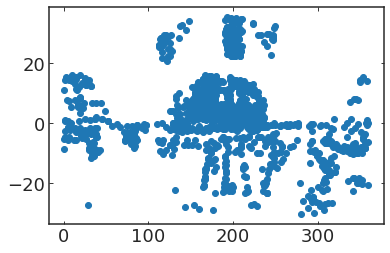

In [13]:
fig, ax=plt.subplots()
ax.scatter(ras0, decs0)

In [14]:
def interpolated(ra, dec, interpolators):
    #Ra dec must in degrees wrapped at 180 degree
    interpoints=np.array([interpolators[0], interpolators[1] ]).T
    return griddata(interpoints, interpolators[-1] , (ra, dec), \
                    method='cubic', fill_value=-1.)
def interpolated_broken(ra, dec,interpolators):
    interpoints=np.array([interpolators[0], interpolators[1] ])
    return  interpn(list(zip(interpoints)), interpolators[-1] , (ra, dec),\
                     fill_value=-1.,  bounds_error=False) 

In [15]:
#from popsims.widefields import  WideField, create_mixed_population,\
#transform_tocylindrical

In [16]:
#field= WideField(footprinttype='uniform')
#field.footprint=SDSS
#trace=field.sample_points(nsample=1e5, Hthin=350, dmin=1, dmax=1000)

In [17]:
thin_dist_list=[]
thick_dist_list=[]
halo_dist_list=[]
discr_ls=[]
discr_bs=[]

for i in tqdm(np.arange(1000)):
    c=sdsscoord[np.random.choice(len(sdsscoord))]
    narro_field=popsims.Pointing(coord=c)
    halo_field=popsims.Pointing(coord=c, density='spheroid')

    narro_field.mag_limits=dict(zip(['VISTA_{}'.format(k) for k in VISTA_DEPTHS.keys()],\
             [(0, VISTA_DEPTHS[k]) for k in VISTA_DEPTHS.keys()]))
    thin_dist_list +=list(narro_field.draw_distances(0.1, 1000,350,  nsample=1e3))
    thick_dist_list +=list(narro_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    halo_dist_list +=list(halo_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    discr_ls += [c.galactic.l.value]
    discr_bs += [c.galactic.b.value]

In [18]:
#np.save('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy',\
#        {'thind':thin_dist_list ,\
#         'thickd':thick_dist_list ,\
#         'halod': halo_dist_list,\
#         'l': discr_ls ,\
#         'b': discr_bs}, allow_pickle=True)

In [19]:
grid=np.arange(14, 40)

In [20]:
dictionary=np.load('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy', allow_pickle=True)
dist_dictionary=dictionary.flatten()[0]
thin_dist_list= dist_dictionary['thind']
thick_dist_list= dist_dictionary['thickd']
halo_dist_list= dist_dictionary['halod']
discr_ls = dist_dictionary['l']
discr_bs = dist_dictionary['b']

In [21]:
from popsims import galaxy

In [22]:
max_distances={}
for g in grid:
    pol=galaxy.POLYNOMIALS['absmags']['dwarfs']['VISTA_J']['fit']
    max_distances[g]=galaxy.get_distance(pol(g), 19.5)

In [23]:
max_distances

{14: 1215.8906815661878,
 15: 930.714372748773,
 16: 731.0405403202573,
 17: 585.028209731382,
 18: 474.7558522929653,
 19: 389.6280835759065,
 20: 323.0464286242746,
 21: 270.65917500516787,
 22: 229.4203802111747,
 23: 197.07930508783699,
 24: 171.901003161582,
 25: 152.50821876362048,
 26: 137.78296532993255,
 27: 126.79339899465874,
 28: 118.72714053238609,
 29: 112.82146904828599,
 30: 108.28830155927707,
 31: 104.24218790524117,
 32: 99.65688430069622,
 33: 93.40049055233249,
 34: 84.41763782828791,
 35: 72.10290378318535,
 36: 56.789995896314075,
 37: 40.065140131686796,
 38: 24.47188107060626,
 39: 12.44227132539806}

In [24]:
def resample_distance(df, dmax_dict, population ):
    df['d']=np.nan
    if population=='thin_disk':
        ds=np.array(thin_dist_list)
    if population=='thick_disk':
        ds=np.array(thick_dist_list)
    if population=='halo':
        ds=np.array(halo_dist_list)
    ds=np.array(ds)
    df['spt_r']=np.round(df.spt)
    
    dx= ds[ds< dmax_dict[float(df.spt_r.iloc[0])] ]
    df['d']= np.random.choice(dx, len(df))
    return df
def sample_distance_properly(df, dmax_dict, population='thin_disk'):
    df['spt_r']=np.round(df.spt)
    groups=[]
    for g in tqdm( df.groupby('spt_r')):
        groups.append(resample_distance(g[1], dmax_dict, population))
    return pd.concat(groups)

def interpolate_sdss(ra, dec):
    interpolators=[a.to(u.degree).value, b.to(u.degree).value, np.ones_like(a)]
    return interpolated(ra, dec, interpolators )

def apply_sdss_selection(df):
    entiregalaxy=SkyCoord(l=df.l*u.radian,\
                     b=df.b*u.radian, frame='galactic')
    
    gridra=Angle(entiregalaxy.icrs.ra.to(u.radian))
    gridra.wrap_at('180d', inplace=True)
    griddec=Angle(entiregalaxy.icrs.dec.to(u.radian))
    griddec.wrap_at('180d', inplace=True)

    selectionfunction=interpolate_sdss(gridra.to(u.degree).value, \
                                                  griddec.to(u.degree).value)
    df['SDSS_selection']= selectionfunction
    df['ra']=gridra
    df['dec']=griddec
    return df

def apply_color_cuts(df):
    bools=[]
    for k in COLOR_CUTS.keys():
        xkey, ykey= k.split('-')
        print (xkey, ykey)
        if COLOR_CUTS[k][-1]=='greater':
            bools.append(df['{}'.format(xkey.upper())]-df['{}'.format(ykey.upper())] >= COLOR_CUTS[k][0])
        if COLOR_CUTS[k][-1]=='less':
            bools.append(df['{}'.format(xkey.upper())]-df['{}'.format(ykey.upper())] <= COLOR_CUTS[k][0])
    return np.logical_and.reduce(bools)
    

def apply_line_cuts(df):
    bools=[]
    for k in LINE_CUTS.keys():
        cut=LINE_CUTS[k]
        xdata=None
        ydata=None
        
        if cut['xtype']=='color':
             xdata=df[cut['x'].split('-')[0]]-df[cut['x'].split('-')[1]]
        if cut['xtype']=='computed':
            xdata=df[cut['x']]
            
        if cut['ytype']=='color':
             ydata=df[cut['y'].split('-')[0]]-df[cut['y'].split('-')[1]]
                
        if cut['ytype']=='computed':
            ydata=df[cut['y']]
        
        slope= cut['m']
        b= cut['b']
        
        if cut['condition'] =='greater':
            bools.append(ydata >= slope*xdata+b)
        if cut['condition'] =='less':
            bools.append(ydata <= slope*xdata+b)
            
    return np.logical_and.reduce(bools)

In [25]:
mag_keys0=['VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_Z', \
 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K']

In [26]:
def apply_all_magnitude_color_cuts(df):
    other_bools=[]
    for k in PS1_DEPTHS.keys():
        other_bools.append((df['PANSTARRS_{}'.format(k)]<PS1_DEPTHS[k]).values)
    for k in SDSS_DEPTHS.keys():
        other_bools.append((df['SDSS_{}'.format(k)]<SDSS_DEPTHS[k]).values)
    for k in VISTA_DEPTHS.keys():
        other_bools.append((df['VISTA_{}'.format(k)]<VISTA_DEPTHS[k]).values)
    for k in OTHER_CUTS.keys():
        other_bools.append((df['{}'.format(k)]< OTHER_CUTS[k]).values)
    
    tot_bools=np.logical_and.reduce(other_bools)
    
    
    return tot_bools

In [27]:
def sample_distance_from_d3(dmax, nsample):
    ##random choice from d^3
    d=np.linspace(0.1, dmax, 1000)
    cdf=(d**3)/np.nanmax(d**3)
    return popsims.tools.random_draw(d, cdf, nsample=nsample)

In [28]:
k=14
nsample=10000
halo_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
df_halo=galaxy.create_pop(bfraction=0.2,\
                         model='roman2020',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample,\
        distances= halo_dist_list_arr[halo_dist_list_arr<2*max_distances[k]],\
                         population='halo', poptype='dwarfs')

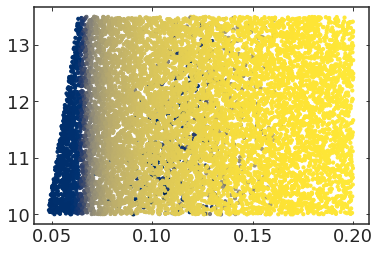

In [29]:
fig, ax=plt.subplots()
ax.scatter(df_halo.mass, df_halo.age,  c=df_halo.temperature, cmap='cividis', s=10)

In [30]:
df_halo.columns

Index(['VISTA_Z', 'abs_VISTA_Z', 'VISTA_Y', 'abs_VISTA_Y', 'VISTA_J',
       'abs_VISTA_J', 'VISTA_H', 'abs_VISTA_H', 'VISTA_KS', 'abs_VISTA_KS',
       'UKIDSS_Z', 'abs_UKIDSS_Z', 'UKIDSS_J', 'abs_UKIDSS_J', 'UKIDSS_H',
       'abs_UKIDSS_H', 'UKIDSS_K', 'abs_UKIDSS_K', 'mass', 'age',
       'temperature', 'luminosity', 'is_binary', 'spt', 'prim_spt', 'sec_spt',
       'pri_mass', 'sec_mass', 'prim_luminosity', 'sec_luminosity', 'scale',
       'scale_unc', 'scale_times_model', 'd', 'l', 'b', 'r', 'z', 'Vr', 'Vphi',
       'Vz'],
      dtype='object')

In [31]:
#redra ibjects from halo thin or thick based on the max dista
def resample_by_max_distance(nsample=1e4):
    df_list=[]
    for k in max_distances.keys():
        if max_distances[k] >200:
            #make distance array array
            thin_dist_list_arr=np.array(thin_dist_list)
            thick_dist_list_arr=np.array(thick_dist_list)
            halo_dist_list_arr=np.array(halo_dist_list)
        else:
            thin_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
            thick_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
            halo_dist_list_arr=sample_distance_from_d3(2*max_distances[k], int(1e5))
        
        
        #use metal-rich models but absolute mag relations for metal poor
        df_thin=galaxy.create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample, \
            distances= thin_dist_list_arr[thin_dist_list_arr<2*max_distances[k]],\
                  poptype='dwarfs')
        
        df_thick=galaxy.create_pop(bfraction=0.2,\
                          model='burrows2001',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample, \
        distances= thick_dist_list_arr[thick_dist_list_arr<2*max_distances[k]],\
                         population='thick_disk', poptype='dwarfs')
        
        df_halo=galaxy.create_pop(bfraction=0.2,\
                         model='roman2020',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=2*nsample,\
        distances= halo_dist_list_arr[halo_dist_list_arr<2*max_distances[k]],\
                         population='halo', poptype='dwarfs')
        
        df_thin['population']='thin_disk'
        df_thick['population']='thick_disk' 
        df_halo['population']='halo'
        
        #make magnitudes and distance cuts righ aay
        thin_bool=np.logical_and.reduce([df_thin.spt>=k, df_thin.spt<k+1, \
                                         df_thin.d <2*max_distances[k]])
                                        #apply_all_magnitude_color_cuts(df_thin)])
        
        thick_bool=np.logical_and.reduce([df_thick.spt>=k, df_thick.spt<k+1, \
                                         df_thick.d <2*max_distances[k]])
                                         # apply_all_magnitude_color_cuts(df_thick)])
        
        halo_bool=np.logical_and.reduce([df_halo.spt>=k, df_halo.spt<k+1, \
                                         df_halo.d <2*max_distances[k]])
                                       #  apply_all_magnitude_color_cuts(df_halo)])
        
        print ('thin for spt {} {}'.format(k, len(df_thin.loc[thin_bool])))
        print ('thick for spt {} {}'.format(k, len(df_thick.loc[thick_bool])))
        print ('halo for spt {} {}'.format(k, len(df_halo.loc[halo_bool])))
        df_thin_small_df=(df_thin.loc[thin_bool]).reset_index(drop=True)
        df_thick_small_df=(df_thick.loc[thick_bool]).reset_index(drop=True)
        df_halo_small_df=(df_halo.loc[halo_bool]).reset_index(drop=True)
    
        #if no thick disk candidates
        if len(df_thin_small_df) >1:
            df_list.append( df_thin_small_df.sample(n=int(nsample), replace=True))
        
        if len(df_thick_small_df) >1:
            df_list.append( df_thick_small_df.sample(n=int(nsample), replace=True))
        
        if len(df_halo_small_df) >1:
            df_list.append( df_halo_small_df.sample(n=int(nsample), replace=True))
        
            #
        #df_list.append(pd.concat([
        #     df_thick_small_df.sample(n=int(10*nsample), replace=True), \
        #      df_halo_small_df.sample(n=int(10*nsample), replace=True)]).reset_index(drop=True))
        
        del df_thin_small_df
        del df_thick_small_df
        del df_halo_small_df
        
    df0=pd.concat(df_list).reset_index(drop=True)
    #us relations from Rocio for SDSSS
    df=galaxy.pop_mags_from_type(df0.spt.values, d=df0.d.values, \
                keys=['SDSS_R', 'SDSS_I', 'SDSS_Z'], reference='kiman2019').join(df0, rsuffix='_rocio').reset_index(drop=True)
    
    #add best relations
    df= galaxy.pop_mags_from_type(df.spt.values, d=df.d.values, \
                keys=['PANSTARRS_R', 'PANSTARRS_I', 'PANSTARRS_Z', \
                      'PANSTARRS_Y'], reference='best2012').join(df).reset_index(drop=True)
    
    #df=df.drop(['abs_SDSS_R', 'abs_SDSS_I', 'abs_SDSS_Z', 'SDSS_R', 'SDSS_I', 'SDSS_Z'], axis=1).rename(columns={'SDSS_R_rocio': 'SDSS_R',\
    #           'abs_SDSS_R_rocio': 'abs_SDSS_R',\
    #           'SDSS_I_rocio': 'SDSS_I',\
    #           'abs_SDSS_I_rocio': 'abs_SDSS_I',\
    #           'SDSS_Z_rocio': 'SDSS_Z',\
    #           'abs_SDSS_Z_rocio': 'abs_SDSS_Z'}).reset_index(drop=True)
    
    #use default stuff for 2MASS 
    df['abs_2MASS_J']=spe.typeToMag(df.spt.values, '2MASS J')[0]
    df['abs_2MASS_H']=spe.typeToMag(df.spt.values, '2MASS H')[0]
    df['abs_2MASS_K']=spe.typeToMag(df.spt.values, '2MASS K')[0]
    df['2MASS_J']=df.abs_2MASS_J+5*np.log10(df.d/10.0)
    df['2MASS_H']=df.abs_2MASS_H+5*np.log10(df.d/10.0)
    df['2MASS_K']=df.abs_2MASS_K+5*np.log10(df.d/10.0)

    #Add
    sd_bool=(df.population != 'thin_disk').values
    for k in ['SDSS_Z', 'SDSS_R', 'SDSS_Z', '2MASS_J', '2MASS_H', '2MASS_KS']:

        df.loc[sd_bool, 'abs_{}'.format(k)]= (spe.typeToMag(df.spt.values[sd_bool], \
                                              k,  reference='zhang2013')[0])
        df.loc[sd_bool, k]=df.loc[sd_bool, 'abs_{}'.format(k)]+5*np.log10(df.d.loc[sd_bool]/10.0)
    
    df['spt_r']=df.spt.apply(np.round)
    color_bools=apply_color_cuts(df)
    other_bools=[]
    for k in OTHER_CUTS.keys():
        other_bools.append((df[k]<OTHER_CUTS[k]).values)
    tot_bools=np.logical_and.reduce(other_bools)
    tot_bools=np.logical_and(color_bools, tot_bools)
    dfn=(df.loc[tot_bools]).reset_index(drop=True)
    return df



In [32]:
dfn=resample_by_max_distance(nsample=5e4)

thin for spt 14 11095
thick for spt 14 4363
halo for spt 14 3358
thin for spt 15 7948
thick for spt 15 3022
halo for spt 15 2534
thin for spt 16 5211
thick for spt 16 1624
halo for spt 16 1950
thin for spt 17 2233
thick for spt 17 593
halo for spt 17 896
thin for spt 18 1150
thick for spt 18 344
halo for spt 18 517
thin for spt 19 1164
thick for spt 19 502
halo for spt 19 519
thin for spt 20 1134
thick for spt 20 489
halo for spt 20 331
thin for spt 21 962
thick for spt 21 344
halo for spt 21 232
thin for spt 22 898
thick for spt 22 183
halo for spt 22 241
thin for spt 23 1009
thick for spt 23 215
halo for spt 23 215
thin for spt 24 1299
thick for spt 24 199
halo for spt 24 220
thin for spt 25 1227
thick for spt 25 170
halo for spt 25 257
thin for spt 26 1197
thick for spt 26 159
halo for spt 26 203
thin for spt 27 1059
thick for spt 27 142
halo for spt 27 180
thin for spt 28 969
thick for spt 28 137
halo for spt 28 200
thin for spt 29 1335
thick for spt 29 171
halo for spt 29 289
thin

In [33]:
#len(dfn[apply_color_cuts(dfn)])

In [34]:
dfn.columns


Index(['PANSTARRS_R', 'abs_PANSTARRS_R', 'PANSTARRS_I', 'abs_PANSTARRS_I',
       'PANSTARRS_Z', 'abs_PANSTARRS_Z', 'PANSTARRS_Y', 'abs_PANSTARRS_Y',
       'SDSS_R', 'abs_SDSS_R', 'SDSS_I', 'abs_SDSS_I', 'SDSS_Z', 'abs_SDSS_Z',
       'VISTA_Z', 'abs_VISTA_Z', 'VISTA_Y', 'abs_VISTA_Y', 'VISTA_J',
       'abs_VISTA_J', 'VISTA_H', 'abs_VISTA_H', 'VISTA_KS', 'abs_VISTA_KS',
       'UKIDSS_Z', 'abs_UKIDSS_Z', 'UKIDSS_J', 'abs_UKIDSS_J', 'UKIDSS_H',
       'abs_UKIDSS_H', 'UKIDSS_K', 'abs_UKIDSS_K', 'mass', 'age',
       'temperature', 'luminosity', 'is_binary', 'spt', 'prim_spt', 'sec_spt',
       'pri_mass', 'sec_mass', 'prim_luminosity', 'sec_luminosity', 'scale',
       'scale_unc', 'scale_times_model', 'd', 'l', 'b', 'r', 'z', 'U', 'V',
       'W', 'population', 'Vr', 'Vphi', 'Vz', 'abs_2MASS_J', 'abs_2MASS_H',
       'abs_2MASS_K', '2MASS_J', '2MASS_H', '2MASS_K', 'abs_2MASS_KS',
       '2MASS_KS', 'spt_r'],
      dtype='object')

In [35]:
#dfn=dfn.sample(n=int(1e5), replace=True )
#dfn=df.sample(n= int(1e4), replace=True )

[Text(0.5, 0, 'Distance')]

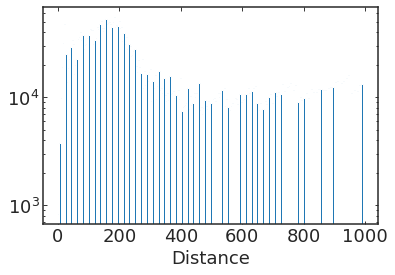

In [36]:
fig, ax=plt.subplots()
h=plt.hist(dfn.d, bins='auto', log=True)
ax.set(xlabel='Distance')

In [37]:
for g in dfn.groupby('spt_r'):
    print (g[0], len(g[1]))

14.0 95406
15.0 83786
16.0 235528
17.0 98350
18.0 182574
19.0 135793
20.0 144151
21.0 161370
22.0 139953
23.0 147756
24.0 148304
25.0 153047
26.0 146964
27.0 160238
28.0 133621
29.0 147755
30.0 168742
31.0 128253
32.0 160344
33.0 148732
34.0 146270
35.0 140184
36.0 177422
37.0 147823
38.0 118562
39.0 94734
40.0 54338


In [38]:
halo_bool=(dfn.population !='thin_disk').values

In [39]:
dfn_coord=SkyCoord(l=dfn.l.values*u.degree, b=dfn.b.values*u.degree, frame='galactic')

In [40]:
dfn['ra']=None
dfn['dec']=None
dfn['ra']=dfn_coord.icrs.ra.to(u.degree).value
dfn['dec']=dfn_coord.icrs.dec.to(u.degree).value

In [41]:
tqdm.pandas()
motion_df=dfn[['ra', 'dec', 'd', 'U', 'V', \
       'W' ]].progress_apply(lambda x: galaxy.get_proper_motion(*x), axis=1).reset_index(drop=True)

100%|██████████████████████████████| 3800000/3800000 [2:02:01<00:00, 519.00it/s]


In [42]:
dfn.columns

Index(['PANSTARRS_R', 'abs_PANSTARRS_R', 'PANSTARRS_I', 'abs_PANSTARRS_I',
       'PANSTARRS_Z', 'abs_PANSTARRS_Z', 'PANSTARRS_Y', 'abs_PANSTARRS_Y',
       'SDSS_R', 'abs_SDSS_R', 'SDSS_I', 'abs_SDSS_I', 'SDSS_Z', 'abs_SDSS_Z',
       'VISTA_Z', 'abs_VISTA_Z', 'VISTA_Y', 'abs_VISTA_Y', 'VISTA_J',
       'abs_VISTA_J', 'VISTA_H', 'abs_VISTA_H', 'VISTA_KS', 'abs_VISTA_KS',
       'UKIDSS_Z', 'abs_UKIDSS_Z', 'UKIDSS_J', 'abs_UKIDSS_J', 'UKIDSS_H',
       'abs_UKIDSS_H', 'UKIDSS_K', 'abs_UKIDSS_K', 'mass', 'age',
       'temperature', 'luminosity', 'is_binary', 'spt', 'prim_spt', 'sec_spt',
       'pri_mass', 'sec_mass', 'prim_luminosity', 'sec_luminosity', 'scale',
       'scale_unc', 'scale_times_model', 'd', 'l', 'b', 'r', 'z', 'U', 'V',
       'W', 'population', 'Vr', 'Vphi', 'Vz', 'abs_2MASS_J', 'abs_2MASS_H',
       'abs_2MASS_K', '2MASS_J', '2MASS_H', '2MASS_K', 'abs_2MASS_KS',
       '2MASS_KS', 'spt_r', 'ra', 'dec'],
      dtype='object')

In [43]:
motion_halo=pd.DataFrame( galaxy.get_proper_motion_cylindrical(dfn.ra.values, \
                             dfn.dec.values,
                            (dfn.d.values)/1000,
                             dfn.Vr.values,
                            (dfn.Vphi.values)/(dfn.d.values+8300.*u.pc.to(u.km)),
                            dfn.Vz.values))

In [44]:
#assert len(dfj)==len(dfn)

In [45]:
dfn=dfn.reset_index(drop=True)

In [46]:
dfj=dfn.join(motion_df).reset_index(drop=True)

In [47]:
halo_bool=dfj.population=='halo'

In [48]:
#computer proper motions for halo star
dfj.loc[halo_bool, 'RV'] = motion_halo[halo_bool]['RV'].values
dfj.loc[halo_bool, 'mu_alpha'] = motion_halo[halo_bool]['mu_alpha'].values
dfj.loc[halo_bool, 'mu_delta']= motion_halo[halo_bool]['mu_delta'].values

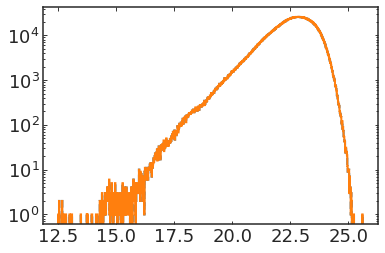

In [49]:
fig, ax=plt.subplots()
for k in PS1_DEPTHS.keys():
    h=plt.hist(dfj['PANSTARRS_{}'.format(k)], bins='auto', histtype='step',\
               lw=2, log=True, linestyle='--')
    h=plt.hist(dfn['PANSTARRS_{}'.format(k)].values, bins='auto',\
               histtype='step', lw=2, log=True)

In [50]:
dfj.columns

Index(['PANSTARRS_R', 'abs_PANSTARRS_R', 'PANSTARRS_I', 'abs_PANSTARRS_I',
       'PANSTARRS_Z', 'abs_PANSTARRS_Z', 'PANSTARRS_Y', 'abs_PANSTARRS_Y',
       'SDSS_R', 'abs_SDSS_R', 'SDSS_I', 'abs_SDSS_I', 'SDSS_Z', 'abs_SDSS_Z',
       'VISTA_Z', 'abs_VISTA_Z', 'VISTA_Y', 'abs_VISTA_Y', 'VISTA_J',
       'abs_VISTA_J', 'VISTA_H', 'abs_VISTA_H', 'VISTA_KS', 'abs_VISTA_KS',
       'UKIDSS_Z', 'abs_UKIDSS_Z', 'UKIDSS_J', 'abs_UKIDSS_J', 'UKIDSS_H',
       'abs_UKIDSS_H', 'UKIDSS_K', 'abs_UKIDSS_K', 'mass', 'age',
       'temperature', 'luminosity', 'is_binary', 'spt', 'prim_spt', 'sec_spt',
       'pri_mass', 'sec_mass', 'prim_luminosity', 'sec_luminosity', 'scale',
       'scale_unc', 'scale_times_model', 'd', 'l', 'b', 'r', 'z', 'U', 'V',
       'W', 'population', 'Vr', 'Vphi', 'Vz', 'abs_2MASS_J', 'abs_2MASS_H',
       'abs_2MASS_K', '2MASS_J', '2MASS_H', '2MASS_K', 'abs_2MASS_KS',
       '2MASS_KS', 'spt_r', 'ra', 'dec', 'RV', 'mu_alpha', 'mu_delta', 'Vtan'],
      dtype='object')

In [51]:
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    dfj['redH_{}'.format(k)]=dfj['abs_{}'.format(k)]+\
     5*np.log10((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)+5

[Text(0.5, 0, 'Reduced Proper Motion')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


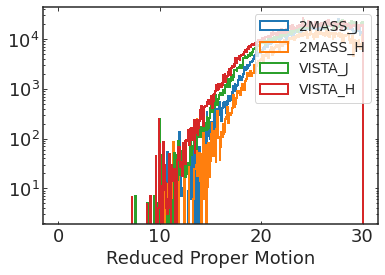

In [52]:
fig, ax=plt.subplots()
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    vals=dfj['redH_{}'.format(k)].values
    h=plt.hist(popsims.dropnans(vals),\
               bins='auto', histtype='step', lw=2, 
               log=True, label=k, range=[0, 30])
plt.legend(fontsize=14)
ax.set(xlabel='Reduced Proper Motion')

In [53]:
dfj=(dfj[apply_line_cuts(dfj) &  apply_color_cuts(dfj) & apply_all_magnitude_color_cuts(dfj) ]).reset_index(drop=True)

SDSS_R SDSS_I
SDSS_I SDSS_Z
SDSS_R SDSS_Z
SDSS_I VISTA_J
SDSS_Z VISTA_J
VISTA_J VISTA_KS


In [54]:
len(dfj)

14944

[None,
 None,
 Text(0.5, 0, 'Proper motion (mas/yr)'),
 Text(0, 0.5, 'Distance (pc)')]

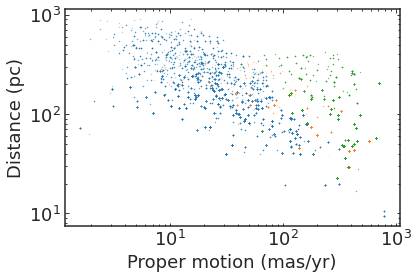

In [55]:
fig, ax=plt.subplots()

bools0=dfj.population=='thin_disk'
bools1=dfj.population=='thick_disk'
bools2=dfj.population=='halo'


h=ax.scatter(((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)[bools0], dfj.d[bools0],  s=.1, alpha=0.5)
h=ax.scatter(((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)[bools1], dfj.d[bools1],  s=.1, alpha=0.1)
h=ax.scatter(((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)[bools2], dfj.d[bools2],  s=.1, alpha=1)

ax.set(xscale='log', yscale='log', xlabel='Proper motion (mas/yr)', \
       ylabel='Distance (pc)', )

In [56]:
len(dfj)

14944

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


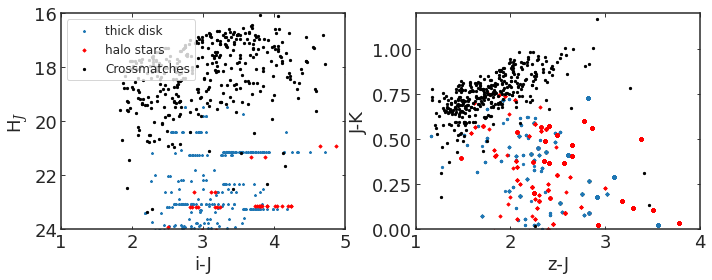

In [57]:
### color-color plots
fig, ax=plt.subplots(figsize=(10, 4), ncols=2)


ax[0].scatter((dfj.SDSS_I[dfj.population=='thick_disk']-\
                dfj['VISTA_J'][dfj.population=='thick_disk']), \
           dfj['redH_{}'.format('VISTA_J')][dfj.population=='thick_disk'], s=5, \
           label='thick disk', marker='*')

ax[0].scatter((dfj.SDSS_I[dfj.population=='halo']-\
            dfj['VISTA_J'].loc[dfj.population=='halo']), \
           dfj['redH_{}'.format('VISTA_J')].loc[dfj.population=='halo'], \
           s=5, label='halo stars', color='r',
              marker='D')

ax[0].scatter((dfl_conct.SDSSi-dfl_conct.Jmag_VHS).values, \
                dfl_conct.Hj, s=5, c='k', label='Crossmatches')



ax[1].scatter((dfj.SDSS_Z[dfj.population=='thick_disk']-\
                dfj.VISTA_J[dfj.population=='thick_disk']), 
          (dfj.VISTA_J[dfj.population=='thick_disk']-\
                dfj.VISTA_KS[dfj.population=='thick_disk']),
           label='thick disk', s=5)

ax[1].scatter((dfj.SDSS_Z[dfj.population=='halo']-\
                dfj.VISTA_J[dfj.population=='halo']), 
          (dfj.VISTA_J[dfj.population=='halo']-\
                dfj.VISTA_KS[dfj.population=='halo']),
           s=5, label='halo stars', color='r',
              marker='D')

ax[1].scatter((dfl_conct.SDSSz-dfl_conct.Jmag_VHS).values, \
              (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS).values, s=5, c='k', label='Crossmatches')



#ax[-1].scatter((dfj.SDSS_I[dfj.population=='thick_disk']-\
#                dfj.SDSS_Z[dfj.population=='thick_disk']), 
#          (dfj['VISTA_J'][dfj.population=='thick_disk']-\
#                dfj['VISTA_KS'][dfj.population=='thick_disk']),
#           label='thick disk', s=.5)
#ax[-1].scatter((dfj.SDSS_I[dfj.population=='halo']-\
#                dfj.SDSS_Z[dfj.population=='halo']), 
#          (dfj['VISTA_J'][dfj.population=='halo']-\
#                dfj['VISTA_KS'][dfj.population=='halo']),
#           s=.5, label='halo stars', color='r',
#              marker='D')
#ax[-1].scatter((dfl_conct.SDSSi-dfl_conct.SDSSz).values, \
#              (dfl_conct.Jmag_VHS-dfl_conct.Kmag_VHS).values, s=0.5, c='k', \
#               label='Crossmatches')

ax[0].set(xlabel='i-J',ylabel=r'H$_J$', xlim=[1., 5], ylim=[24, 16])
#ax[0].axvline(1.9, color='k', linestyle='--')
ax[1].set(xlabel='z-J', ylabel='J-K', xlim=[1, 4], ylim=[0.0, 1.2])
#ax[-1].set(xlabel='i-z', ylabel='J-K', xlim=[0, 3], ylim=[-1, 1.2])

ax[0].legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.savefig('../figures/plot_simulatedcolors_sdss_vhs.pdf')

In [58]:
#GV

In [59]:
dfj['selection_function']=1.

In [60]:
len(dfj)

14944

In [61]:
def get_ncounts(binby='spt', grid=np.arange(15, 40),
               population='thin_disk', df=None):
    
    df=(df[df.population==population]).reset_index(drop=True)
    scale=[df.scale.mean(), df.scale_unc.mean(),df.scale_times_model.mean()]
    NSIM=dict(zip(grid, np.zeros((len(grid), 2))))
    
    df['r_{}'.format(binby)]=df[binby].apply(np.round)
    df=df[df['r_{}'.format(binby)].isin(grid)].reset_index(drop=True)

    for g in tqdm(df.groupby('r_{}'.format(binby))):
        
        sn= len(df[np.logical_and(df.temperature>=450, df.temperature<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        
        #if sd:
        #    b0=np.logical_and(df.temperature>=450, df.temperature<=2100)
        #    b1=df.population=='halo'
        #    nhalo=len(df[np.logical_and(b0, b1)])/sn
        #    scln=scln*nhalo

        
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].selection_function)*scln
    df.drop('r_{}'.format(binby), axis=1)
    return pd.DataFrame(NSIM).T.rename(columns={0: 'N', 1: 'Nunc'})

In [62]:
grid

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39])

In [63]:

thincounts=get_ncounts(grid=grid, population='thin_disk', df=dfj)
thickcounts=get_ncounts(grid=grid,  population='thick_disk', df=dfj)
halocounts=get_ncounts(grid=grid,  population='halo', df=dfj)

100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 1190.26it/s]


In [64]:
#halocounts

In [65]:
import scipy.integrate as integrate
galaxy.Rsun

8300.0

In [66]:
def compute_volume(spt, l, b, h=350):
    dmin=0
    dmax=max_distances[spt]
    if np.isnan(dmax):
        return np.nan
    else:
        ds=np.linspace(dmin, dmax, 1000)
        rd=np.sqrt( (ds * np.cos( b ) )**2 + galaxy.Rsun * (galaxy.Rsun - 2 * ds * np.cos( b ) * np.cos( l ) ) )
        zd=galaxy.Zsun+ ds * np.sin( b - np.arctan( galaxy.Zsun / galaxy.Rsun) )
        rh=galaxy.galactic_density(rd, zd, h)
        return {'thin': integrate.trapz(rh['thin']*(ds**2), x=ds), \
                'thick': integrate.trapz(rh['thick']*(ds**2), x=ds), \
                'halo': integrate.trapz(rh['halo']*(ds**2), x=ds)}
                

In [67]:
volumes={}
for k in grid:
    vs={'thin': 0.0, 'thick': 0.0, 'halo': 0.0}
    for f in tqdm(footprint):
        l=f.galactic.l.radian
        b=f.galactic.b.radian
        v=compute_volume(k, l, b, h=350)
        vs['thin'] +=v['thin']
        vs['thick'] +=v['thick']
        vs['halo'] +=v['halo']
    volumes[k]=vs

100%|██████████████████████████████████████| 1378/1378 [00:03<00:00, 385.27it/s]


In [68]:
#save this, takes too much time to do
volumes_df=pd.DataFrame(volumes).T/len(footprint)

In [69]:
area=5350*(u.degree**2).to(u.radian**2)*(u.radian**2)
area_to_degree=area.to(u.degree**2)

In [70]:
area_to_degree

<Quantity 5350. deg2>

In [71]:
#volumes

In [72]:
#easiest ay is to compute volumes for every field and then
#second easiest thing, simulate an entire sky and do 2d-interpolation over sdss area

In [73]:
#counts['volume']=pd.Series(volumes).T/len(dfn_coord)
#sdcounts['volume']=pd.Series(volumes).T/len(dfn_coord)

[Text(0, 0.5, 'N/radian$^2$')]

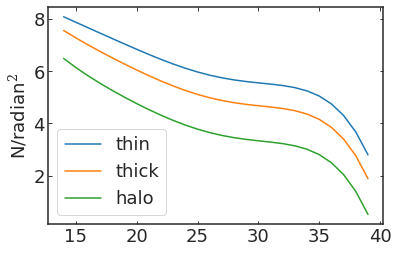

In [74]:
fig, ax=plt.subplots()
volumes_df.thin.apply(np.log10).plot(label='thin', ax=ax)
volumes_df.thick.apply(np.log10).plot(label='thick', ax=ax)
volumes_df.halo.apply(np.log10).plot(label='halo', ax=ax)
ax.legend()
ax.set(ylabel=r'N/radian$^2$')



In [75]:
#list(dfl_conct.columns)

In [76]:
#names used by lodieu
allowed_colors={'SDSS_I-SDSS_Z': ['SDSSi', 'SDSSz'], 
                'MKO_J-MKO_H': ['Jmag', 'Kmag']}
                #'MKO_H-MKO_K':['Hmag', 'Kmag']}


SDSS_I-SDSS_Z
MKO_J-MKO_H


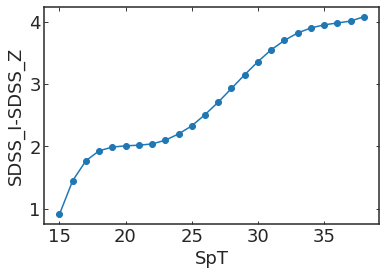

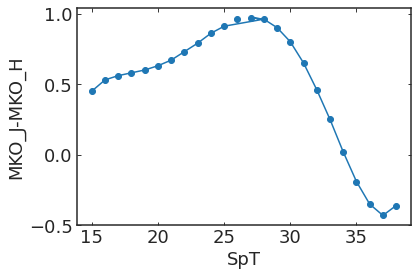

In [77]:
dfl_spts=[]
for c in allowed_colors.keys():
    print (c)
    spgrid=np.arange(10, 40)
    color_grid=spe.typeToColor(spgrid,c ,reference='skrzypek2015',uncertainty=0.,\
                    nsamples=100,verbose=False,forgiving=True)

    fig, ax=plt.subplots()
    ax.scatter(spgrid, color_grid[0])
    f = scipy.interpolate.interp1d(color_grid[0],spgrid,bounds_error=False,fill_value=0.)
    plt.plot(f(color_grid[0]), color_grid[0])
    
    dfl_spts.append(f(dfl_conct[allowed_colors[c][0]]-dfl_conct[allowed_colors[c][-1]]))
    
    
    ax.set(xlabel='SpT', ylabel=c)

(26, 26)

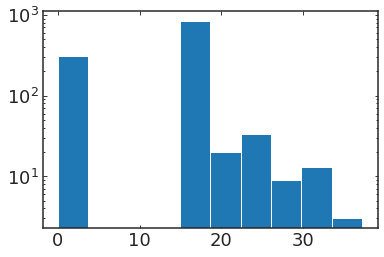

In [78]:
observed_spts=np.nanmedian(dfl_spts, axis=0)
_= plt.hist(observed_spts, log=True)
counts= np.histogram(observed_spts, bins=np.array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
            31, 32, 33, 34, 35, 36, 37, 38, 39, 40])+0.1)
len(counts[0]), len(thickcounts.index)

In [79]:
import popsims.relations as rel
from scipy.interpolate import interp1d

In [80]:
def interpolated_local_lf(unit='teff'):
    teff= rel.kirkpatrick2020LF['bin_center']
    binedges=teff
    if unit=='spt':
       binedges= popsims.teff_to_spt(teff)
    obs=np.array(rel.kirkpatrick2020LF['values'])*1e-3
    unc=np.array(rel.kirkpatrick2020LF['unc'])

    return interp1d( binedges, obs, assume_sorted = False, fill_value = np.nan, bounds_error=False)


In [81]:
lf_interpo=interpolated_local_lf(unit='spt')

AttributeError: module 'popsims' has no attribute 'teff_to_spt'

In [ ]:
len(np.arange(14, 40))

In [ ]:
len(counts[0]), len(counts[-1])

In [ ]:
fig, ax=plt.subplots(figsize=(10, 6))

ax.scatter(np.arange(14, 40), counts[0]/area.to(u.degree**2).value, c='k', label='Data')

ax.step(thincounts.index, (lf_interpo(thincounts.index)*volumes_df.thin.values*area.value/area).to(u.deg**-2), \
        where='mid', label='Interpolated Thin Disk ',  linestyle='dotted',  color='#AAAAAA',  linewidth=3)

ax.step(thincounts.index, (thincounts.N.values*volumes_df.thin.values*area.value/area).to(u.deg**-2),\
        label='Simulated Thin Disk', where='mid', linestyle='-', color='#AAAAAA',  linewidth=3)


ax.step(thickcounts.index, (0.12*lf_interpo(thickcounts.index)*volumes_df.thick.values*area.value/area).to(u.deg**-2), \
        where='mid', label='Interpolated Thick Disk ',  linestyle='dotted',  color='#FF851B',  linewidth=3)

ax.step(thickcounts.index, (thickcounts.N.values*0.12*volumes_df.thick.values*area.value/area).to(u.deg**-2),\
        label='Simulated Thick Disk', where='mid', linestyle='-', color='#FF851B',  linewidth=3)


ax.step(halocounts.index, (0.0025*lf_interpo(halocounts.index)*volumes_df.halo.values*area.value/area).to(u.deg**-2), \
        where='mid', label='Interpolated Halo ',  linestyle='dotted',  color='#0074D9',  linewidth=3)

ax.step(halocounts.index, (halocounts.N.values*0.0025*volumes_df.halo.values*area.value/area).to(u.deg**-2),\
        label='Simulated Halo', where='mid', linestyle='-', color='#0074D9',  linewidth=3)

ax.set_xticks([14, 17, 20,  25, 30, 35, 40])
ax.set_xticklabels(['M4', 'M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])
ax.set( xlabel='Spectral Type',  ylabel=r'Surface Density (deg $^{-2}$)', yscale='log')
#ax.grid()
#ax.axhline(100, linestyle='--', c='k')
ax.legend( loc=(0.7, 0.6), fontsize=12)
plt.tight_layout()
ax.minorticks_on()


plt.savefig('../figures/plot_simulatedncounts_sdss_vhs.pdf')

In [ ]:
(2000*u.deg**2).to(u.arcmin**2)

In [ ]:
 (halocounts.N.values*0.0025*volumes_df.halo.values*area.value/area).to(u.deg**-2)

In [ ]:
(thickcounts.N.values*0.12*volumes_df.thick.values*area.value/area).to(u.deg**-2)

In [ ]:
#read in a metal-poor baraffe model
#baraffe=pd.read_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998.csv')
#metpoor=(baraffe[baraffe.metallicity<0]).reset_index(drop=True)

In [ ]:
#metpoor.to_csv(popsims.EVOL_MODELS_FOLDER+'//baraffe1998_metalpoor.csv', index=False)

In [ ]:
demo(maintain_offset="foo")

In [ ]:
demo(mo="foo")

In [ ]:
ages=np.random.uniform(0, 13, int(1e4))
vels=galaxy.get_velocities(ages,  kind='thin_disk').reset_index(drop=True)
velst=galaxy.get_velocities(ages,  kind='thick_disk').reset_index(drop=True)

In [ ]:
fig, ax=plt.subplots()
ax.scatter((velst.U**2+velst.V**2)**0.5, velst.W, s=0.1, label='thin disk')
ax.scatter((vels.U**2+vels.V**2)**0.5, vels.W, s=0.1,  label='thick disk')

In [83]:
sp0= splat.getSpectrum(lucky=True)[0]


Retrieving 1 lucky file



27.0